# Benchmarking explanation methods

Imagine you are a social media manager for a large e-commerce platform with thousands of products. You have been tasked with monitoring user-generated reviews to understand the customer satisfaction. You use an AI model to classify posts/comments into different emotions.

<center><img src='https://media.giphy.com/media/gD7PbhbmVsw1i/giphy.gif'></center>

As you begin to review the classified comments, you notice that the model is able to correctly classify most of comments, but as you dig deeper you realize that some of the posts that the model classifies as not angry, contain subtle hints that customers were not satisfied. You try out different explnations but each of them give you different results. You are unsure if you can trust some or any of these explanations. 

In this scenario, the importance of faithfulness and plausibility in an explainer model becomes paramount. The faithfulness of the model's explanation ensures that the comment's classification is based on accurate and consistent reasoning and able to capture the real intent behind the user's review, while plausibility ensures that the explanation aligns with the platform's policies and is understandable to the social media manager. 

Your task is to use the XAI principles from Week 3 to understand the faithfulness and plausibility of this sentiment model. Let's get started!

# Installation and Imports
We will use same [Ferret](https://ferret.readthedocs.io/en/latest/readme.html) python package to understand the faithfulness and plausibility of model's explanation 

In [ ]:
!pip install scikit-learn==1.0.2
!pip install -U ferret-xai==0.4.1
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 376.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.0 MB/s eta 0:00:

In [ ]:
## The Usual Suspects
import pandas as pd
import numpy as np  
import torch

## Transformer Models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, pipeline
## Ferret Benchmarker
from ferret import Benchmark

# Emotion Detection Model
Similar to Week 2, let's use the NLP model developed by hugging face🤗 for sentiment(emotion) analysis.  Specifically, we will use `j-hartmann/emotion-english-distilroberta-base` [fine-tune model](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base) to detect emotions in English Text hate speech. Let us leverage on hugging face `transformers` library to load the pre-trained models. See the documentation [here](https://huggingface.co/docs/transformers/v4.25.1/en/autoclass_tutorial#autotokenizer)

In [ ]:
## Before we build our transformer, lets make sure to setup the device.
## To run this notbeook via GPU: Edit -> Notebook settings -> Hardware accelerator -> GPU
## If your GPU is working, device is "cuda"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"

##TODO: Build pre-trained model and tokenizer using  AutoModelForSequenceClassification, AutoTokenizer
## Make sure to load the model onto the device for gpu

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Let us explore the configuration of this model. Use `.config` to get the model configuration, which gives you the model architectures, number of hidden layers, activation function, etc. Most importantly, the class labels.

In [ ]:
##TODO: Print the model configuration. Determine the classification labels and store it in the `class_labels` variable

print(model.config)

##TODO: Get the mapping of class labels as Dictionary
class_labels = list(model.config.label2id)
class_labels

RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "joy",
    "4": "neutral",
    "5": "sadness",
    "6": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

## Emotion Analysis
As you have noticed, the model tries to predict 6 basic emotions and a neutral class:

1. Anger 🤬
2. Disgust 🤢
3. Fear 😨
4. Joy 😀
5. Neutral 😐
6. Sadness 😭
7. Surprise 😲

Let us try some sample texts to see how the model performs in predicting these different emotions. First, we will build our pipeline for classification 




In [ ]:
# TODO: Use `pipeline` from transformers to build classifier and return scores for all classes

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

In [ ]:
# Get the model's prediction on a sample text input. 
example_text1 = "I am super excited about this product!"
classifier(example_text1)

[{'label': 'joy', 'score': 0.9681872725486755}]

In [ ]:
# Get the model's prediction on a sample text input. 
example_text2 = "Your product makes me furious!"
classifier(example_text2)

[{'label': 'anger', 'score': 0.9818695187568665}]

What are your initial thoughts about the model performance? Let us see if your thinking matches with the explainers explanations.

# Anger Explainer 😤
Using Ferret XAI, we will benchmark our pre-trained model from huggingface. See [Benchmark](https://ferret.readthedocs.io/en/latest/readme.html#visualization) documentation 
<center><img src='https://media.giphy.com/media/J3T9b6JFfxFT2/giphy.gif'></center>

In [ ]:
##TODO: Build explainer using `Benchmark` function 
bench = Benchmark(model, tokenizer)

In [ ]:
## Let us verify our predictions for example_text2
bench.score(example_text2)

{'anger': 0.9818695187568665,
 'disgust': 0.0034486670047044754,
 'fear': 0.002584586851298809,
 'joy': 0.000593878619838506,
 'neutral': 0.006782401353120804,
 'sadness': 0.0018764181295409799,
 'surprise': 0.0028446034993976355}

In [ ]:
## TODO: Specify the target class to anger

target_class = 0

In [ ]:
# Explanations (Darker red => higher contrib; darker blue => lower contrib)
# In Roberta tokenizers, the space between words is represented by a special character Ġ

## TODO: Generate explanation for anger class and show the explanations in a table
## Use example_text2 for this explanation

explanations_anger = bench.explain(example_text2, target=target_class)
bench.show_table(explanations_anger)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Token,Your,Ġproduct,Ġmakes,Ġme,Ġfurious,!
Partition SHAP,0.01,-0.01,0.02,0.19,0.69,0.08
LIME,0.04,-0.01,0.01,0.01,0.86,0.08
Gradient,0.06,0.10,0.10,0.11,0.31,0.09
Gradient (x Input),-0.11,0.11,0.04,0.09,0.29,0.14
Integrated Gradient,0.06,-0.05,0.15,0.09,0.45,-0.13
Integrated Gradient (x Input),0.04,-0.02,0.03,0.17,0.68,0.06


# Evaluating Faithfulness
 
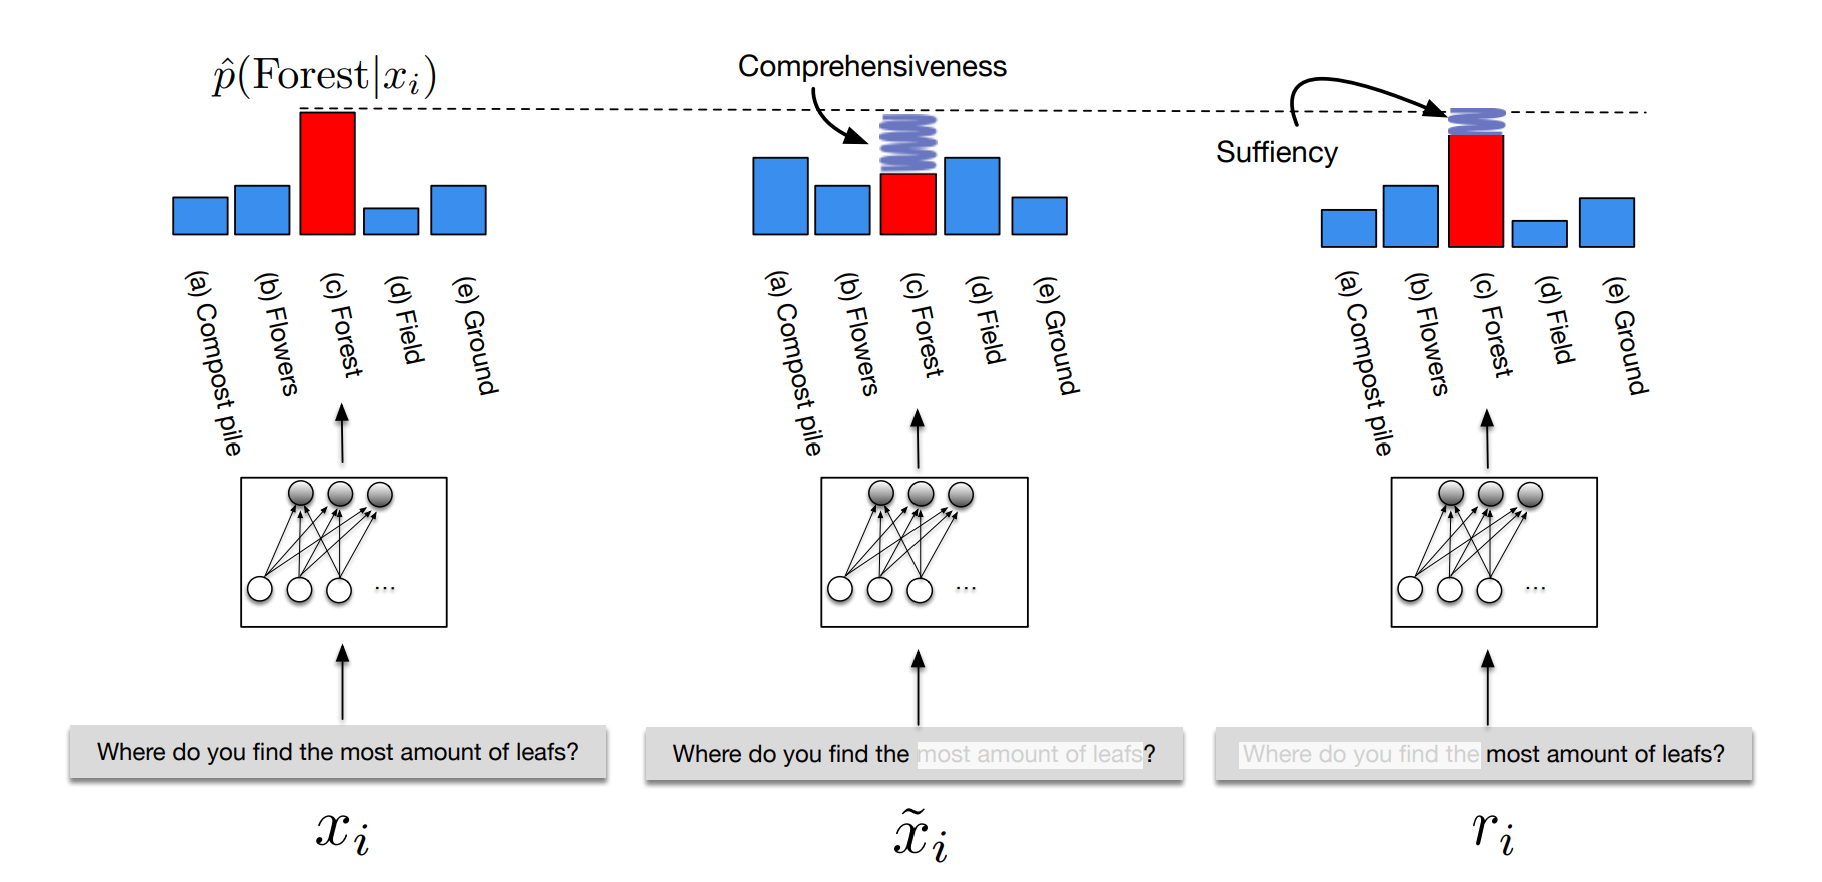
**AOPC Comprehensiveness.** Comprehensiveness measures the drop in the model probability if the relevant tokens of the explanations are removed. We measure comprehensiveness via the Area Over the Perturbation Curve by progressively considering the most important tokens, from 1 to #tokens and then averaging the result. The higher the value, the more the explainer is able to select the relevant tokens for the prediction.

**AOPC Sufficiency.** Sufficiency captures if the tokens in the explanation are sufficient for the model to make the prediction. 

**Correlation with Leave-One-Out scores.** We first compute the leave-one-out scores by computing the prediction difference when one feature at the time is omitted. We then measure the Spearman correlation with the explanations.

In [ ]:
## TODO: Evaluate the explantions using the `evaluate_explanations` method
# Specify the target class

evaluate_anger_explanations = bench.evaluate_explanations(explanations_anger, target=target_class)

## TODO: Use `show_evaluation_table` to show the evaluated explanations

bench.show_evaluation_table(evaluate_anger_explanations)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.90,-0.00,0.47
LIME,0.95,0.00,0.33
Gradient,0.76,-0.00,0.33
Gradient (x Input),0.89,0.00,0.20
Integrated Gradient,0.66,0.00,0.47
Integrated Gradient (x Input),0.91,-0.00,0.60


# Evaluating Plausibility

Plausibility evaluates how well the explanation agrees with human rationale. We use Area Under the Precision Recall curve (AUPRC) (auprc_plau), token-level f1-score (token_f1_plau) and average Intersection-Over-Union (IOU)(token_iou_plau) for evaluating plausibility.

* **Area Under the Precision Recall curve (AUPRC)** is computed by sweeping a threshold over token scores.

* **Token-level f1-score** is the token-level F1 scores derived from the token-level precision and recall. 

* **Intersection-Over-Union (IOU)** measures overlap of the tokens they cover divided by the size of their union.



In [ ]:
## TODO: Create tokens for the example_text2 using `tokenizer`
# Note: The tokenizers for roberta use a special character Ġ to represent white spaces. 
# So the first word in the sentence will not have the Ġ.    

tokens = tokenizer.tokenize(example_text2)
print(tokens)

['Your', 'Ġproduct', 'Ġmakes', 'Ġme', 'Ġfurious', '!']


Let us evaluate if the explanations are plausible🤨. To do this, we will annotate the tokens manually and create a human rationale🧔‍♂️. These rationales should contain the words or phrases that most influenced the annotator's label choice. In this context, if you think the particular token represents `anger`🤬, mark it with 1️⃣ else with 0️⃣. Make sure to annotate all the tokens in the same order. 

In [ ]:
## TODO: Create a list of 0s and 1s to indicate if the token was useful for making the prediction
## Make sure the list is of same length as that of tokenized sentence and assertions pass

human_rationale = [0,0,1,0,1,1]
assert len(tokens) == len(human_rationale), "Length of human rationales does not match the number of tokens"
assert set(human_rationale).issubset({0, 1}), "Human rationales must be values of 0 or 1"

In [ ]:
## TODO: Evaluate the explantions using the `evaluate_explanations` method
# Specify the target class and human rationale

expl_eval_plaus = bench.evaluate_explanations(
      explanations_anger,
      target=target_class,
      human_rationale = human_rationale
      )

bench.show_evaluation_table(expl_eval_plaus)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo,auprc_plau,token_f1_plau,token_iou_plau
Partition SHAP,0.90,-0.00,0.47,0.76,0.75,0.60
LIME,0.95,0.00,0.33,0.85,0.75,0.60
Gradient,0.76,-0.00,0.33,0.71,0.75,0.60
Gradient (x Input),0.89,0.00,0.20,0.85,0.75,0.60
Integrated Gradient,0.66,0.00,0.47,0.83,0.57,0.40
Integrated Gradient (x Input),0.91,-0.00,0.60,0.71,0.75,0.60


In [ ]:
## TODO: Evaluate the explantions using the `evaluate_explanations` method. We will also limit the human rationales to top_k
## Specify the target class, human rationale and top_k_rationale
## Use a valid value for top_k_rationale

expl_eval_plaus = bench.evaluate_explanations(
      explanations_anger,
      target=target_class,
      human_rationale = human_rationale,
      top_k_rationale = 3
 )

bench.show_evaluation_table(expl_eval_plaus)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo,auprc_plau,token_f1_plau,token_iou_plau
Partition SHAP,0.90,-0.00,0.47,0.76,0.67,0.50
LIME,0.95,0.00,0.33,0.85,0.67,0.50
Gradient,0.76,-0.00,0.33,0.71,0.67,0.50
Gradient (x Input),0.89,0.00,0.20,0.85,0.67,0.50
Integrated Gradient,0.66,0.00,0.47,0.83,0.67,0.50
Integrated Gradient (x Input),0.91,-0.00,0.60,0.71,0.67,0.50


# Outro
Yay you made it 👏👏
<center><img src= "https://media.giphy.com/media/12d19apJyRsmA/giphy.gif"/></center>


---
Answer these following questions


1. Which is most faithful explainer? Give reasoning
2. Which is most plausible explainer? Explain why
3. Do you think you can rely on this emotion classification model based on faithfulness and plausibility of the best explainers?





1. LIME is the most faithful explainer according to AOPC comprehensive score. Although IGxInput and SHAP came very close. AOPC sufficiency score is not useful to determine which explainer is most faithful for this particular example. loo does not have similar agreement with AOPC comprehensive score.

2. I can't give a definitive conclusion on the plausibility, the results are not very discriminative.

3. I am not really sure, need much more experiments and deep dive, I can't conclude based on one simple example.

# Bonus

Wow! Super proud you made it till here. The journey from here onwards is not for the faintest of hearts 😜. Are you ready for deeper emotional connect? Ok, try this bonus quest!🪙

For this project, we have only considered one emotion so far and evaluated the explanation on a single target class. 


1. Evaluate the faithfulness of explainers using all classes. Is your most faithful explainer different from what it was previously? Explain your reasoning.
2. Evaluate the plausibility of explainer using the a `sample_text` of your own choice but for all classes considering one target at a time. Do you notice any difference in the plausibilities for different emotions for the same explainer? If yes, why do you think so.
3. Lastly, based on the faithfulness and plausibility of explainers which classes do you think the model is accurate classify and for which classes is it  failing?









<center><img src='https://media.giphy.com/media/OK2gOT81vcSdi/giphy.gif'/></center>

In [ ]:
## Start your work here
# anger, disgust, fear, joy, neutral=4, sadness, surprise = 6
# ---- test neutral

target_class = 4
explanations_neutral = bench.explain(text=example_text2, target=target_class)
bench.show_table(explanations_neutral)

evaluate_neutral_explanations=bench.evaluate_explanations(explanations_neutral, target_class)
bench.show_evaluation_table(evaluate_neutral_explanations)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,-0.00,-0.92,0.07
LIME,-0.00,-0.90,0.33
Gradient,-0.41,0.00,-0.33
Gradient (x Input),0.00,-0.81,0.07
Integrated Gradient,-0.51,-0.00,0.33
Integrated Gradient (x Input),0.00,-0.88,0.33


In [ ]:
target_class = 6
explanations_surprise = bench.explain(text=example_text2, target=target_class)
bench.show_table(explanations_surprise)

evaluate_surprise_explanations=bench.evaluate_explanations(explanations_surprise, target_class)
bench.show_evaluation_table(evaluate_surprise_explanations)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.00,-0.59,0.73
LIME,0.00,-0.54,0.60
Gradient,-0.06,0.00,-0.20
Gradient (x Input),-0.00,-0.03,-0.07
Integrated Gradient,-0.04,-0.18,0.20
Integrated Gradient (x Input),0.00,-0.35,0.60
